In [1]:
# RNN (순환 신경망)

# 시간적으로 연속성이 있는 데이터를 처리하려고 고안된 인공신경망
# 기억을 갖고 새로운 입력이 들어올 때마다 조금씩 기억을 수정하여 결국 모든 입력 전체를 요약한 것과 같은 기억을 갖게 된다.

# 일대일 : 순환이 없기에 RNN 이라고 말하기 어렵다. 순방향 네트워크.
# 일대다 : 입력 하나, 출력 다수. 이미지 캡션 ( 이미지를 입력해서 이미지에 대한 설명을 문장으로 출력 )이 대표적.
# 다대일 : 입력이 다수, 출력이 하나. 감성 분석기 ( 문장을 입력하여 긍정 혹은 부정을 출력 )이 대표적.
# 다대다 : 입출력 모두 다수. 언어를 번역하는 자동 변역기가 대표적.

In [2]:
# simple RNN 구현

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dropout, Dense
from sklearn.preprocessing import MinMaxScaler

In [3]:
df= pd.read_csv("/content/drive/MyDrive/DeepLearning/RNN_sample.csv", header = 0)

In [4]:
df

,regdate,temp1,temp2,temp3,temp4,temp5,temp6
0,2019-04-10 8:00,19.5,-81.4,-9.7,32.4,50.4,34.4
1,2019-04-10 8:01,20.8,-81.0,-5.1,32.3,51.6,34.2
2,2019-04-10 8:02,21.5,-80.6,-1.6,32.2,52.6,33.9
3,2019-04-10 8:08,33.0,-78.9,-20.8,33.7,51.5,36.9
4,2019-04-10 8:09,33.8,-78.6,-25.1,33.6,48.9,35.2
...,...,...,...,...,...,...,...
152,2019-04-10 10:55,36.9,-82.2,-24.8,35.8,42.7,37.3
153,2019-04-10 10:56,23.8,-82.4,-20.5,34.7,45.0,37.2
154,2019-04-10 10:57,13.5,-82.3,-16.6,34.0,46.8,36.4
155,2019-04-10 10:58,17.1,-82.1,-16.9,33.5,48.5,35.8


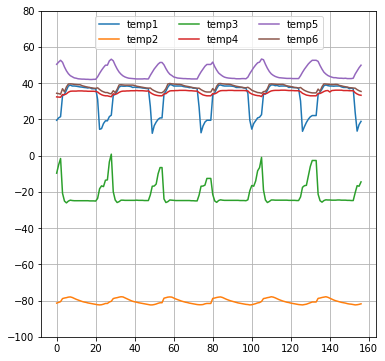

In [11]:
pl.figure(figsize = (6, 6))

pl.plot(df['temp1'], label = 'temp1')
pl.plot(df['temp2'], label = 'temp2')
pl.plot(df['temp3'], label = 'temp3')
pl.plot(df['temp4'], label = 'temp4')
pl.plot(df['temp5'], label = 'temp5')
pl.plot(df['temp6'], label = 'temp6')

pl.grid()
pl.legend(loc = "upper center", ncol = 3)
pl.ylim(-100, 80)
pl.show()

In [12]:
df['regdate'] = pd.to_datetime(df.regdate, format = "%Y-%m-%d %H:%M")           # 문자열을 날짜 형식으로 변환

In [15]:
df.index = df['regdate']                                                        # 날짜를 인덱스로 사용
data = df.sort_index(ascending = True, axis = 0)                                # axis = 0 이면 열단위, 1이면 행단위 정렬

In [16]:
data.head()

,regdate,temp1,temp2,temp3,temp4,temp5,temp6
regdate,,,,,,,
2019-04-10 08:00:00,2019-04-10 08:00:00,19.5,-81.4,-9.7,32.4,50.4,34.4
2019-04-10 08:01:00,2019-04-10 08:01:00,20.8,-81.0,-5.1,32.3,51.6,34.2
2019-04-10 08:02:00,2019-04-10 08:02:00,21.5,-80.6,-1.6,32.2,52.6,33.9
2019-04-10 08:08:00,2019-04-10 08:08:00,33.0,-78.9,-20.8,33.7,51.5,36.9
2019-04-10 08:09:00,2019-04-10 08:09:00,33.8,-78.6,-25.1,33.6,48.9,35.2


In [24]:
nd = pd.DataFrame(index = range(0, len(df)), columns = ['regdate', 'temp1'])    # temp1 만 새로운 데이터 프레임으로 추출

for i in range(len(data)):

  nd['regdate'][i] = data['regdate'][i]
  nd['temp1'][i] = data['temp1'][i]  

nd.index = nd.regdate
nd.drop('regdate', axis = 1, inplace = True)

In [25]:
nd.head()

,temp1
regdate,
2019-04-10 08:00:00,19.5
2019-04-10 08:01:00,20.8
2019-04-10 08:02:00,21.5
2019-04-10 08:08:00,33.0
2019-04-10 08:09:00,33.8


In [28]:
fd = nd.values                                                                  # array로 변환
fd[ :5]

array([[19.5],
       [20.8],
       [21.5],
       [33.0],
       [33.8]], dtype=object)

In [50]:
# 스캐일러 객체 생성 및 정규화 실행

scaler = MinMaxScaler(feature_range = (0,1))
sd = scaler.fit_transform(fd)

tr = sd[ :120]                                                                  # 학습데이터, 검정데이터 분리
te = sd[120: ]

print(tr[ :5], te[ :5])

[[0.26765799]
 [0.31598513]
 [0.34200743]
 [0.76951673]
 [0.79925651]] [[0.94795539]
 [0.93680297]
 [0.93680297]
 [0.93680297]
 [0.91821561]]


In [51]:
xtr, ytr = [], []                                                               # 배열 초기화
xte, yte = [], []

for i in range(10, len(tr)):

  xtr.append(sd[i-10:i])
  ytr.append(sd[i, 0])

for i in range(10, len(te)):

  xte.append(sd[i-10:i])
  yte.append(sd[i, 0])

print(xtr[1], ytr[1], xte[1], yte[1])

[[0.31598513]
 [0.34200743]
 [0.76951673]
 [0.79925651]
 [0.88475836]
 [0.97026022]
 [0.98884758]
 [0.97026022]
 [0.97026022]
 [0.96654275]] 0.9591078066914496 [[0.31598513]
 [0.34200743]
 [0.76951673]
 [0.79925651]
 [0.88475836]
 [0.97026022]
 [0.98884758]
 [0.97026022]
 [0.97026022]
 [0.96654275]] 0.9591078066914496


In [52]:
xtr, ytr = np.array(xtr), np.array(ytr)                                         # array로 변환
xte, yte = np.array(xte), np.array(yte)

# simple RNN에 입력하려면 3차원 데이터로 변환 해야함.
xtr = np.reshape(xtr, (xtr.shape[0], xtr.shape[1], 1))
xte = np.reshape(xte, (xte.shape[0], xte.shape[1], 1))

In [53]:
xtr.shape

(110, 10, 1)

In [54]:
# RNN 모델 생성
rnn_md = tf.keras.Sequential([
    
  tf.keras.layers.SimpleRNN(units = 10, return_sequences = True, input_shape = (xtr.shape[1], 1)),
  tf.keras.layers.SimpleRNN(units = 10),
  tf.keras.layers.Dense(1)

])

rnn_md.compile(loss = 'mse', optimizer = 'adam')
rnn_md.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_4 (SimpleRNN)    (None, 10, 10)            120       
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 10)                210       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [55]:
hist_rnn = rnn_md.fit(xtr, ytr, epochs = 20, batch_size = 1, verbose = 1, validation_split= 0.2)

Epoch 1/20
88/88 [==============================] - 2s 16ms/step - loss: 0.1419 - val_loss: 0.0866
Epoch 2/20
88/88 [==============================] - 1s 14ms/step - loss: 0.0630 - val_loss: 0.0573
Epoch 3/20
88/88 [==============================] - 1s 14ms/step - loss: 0.0480 - val_loss: 0.0476
Epoch 4/20
88/88 [==============================] - 1s 13ms/step - loss: 0.0416 - val_loss: 0.0398
Epoch 5/20
88/88 [==============================] - 1s 14ms/step - loss: 0.0352 - val_loss: 0.0370
Epoch 6/20
88/88 [==============================] - 1s 13ms/step - loss: 0.0356 - val_loss: 0.0336
Epoch 7/20
88/88 [==============================] - 1s 13ms/step - loss: 0.0322 - val_loss: 0.0313
Epoch 8/20
88/88 [==============================] - 1s 13ms/step - loss: 0.0296 - val_loss: 0.0363
Epoch 9/20
88/88 [==============================] - 1s 13ms/step - loss: 0.0311 - val_loss: 0.0273
Epoch 10/20
88/88 [==============================] - 1s 13ms/step - loss: 0.0273 - val_loss: 0.0312
Epoch 11/

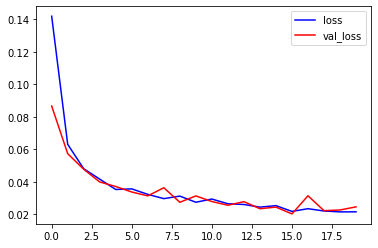

In [56]:
pl.plot(hist_rnn.history['loss'], 'b-', label = 'loss')
pl.plot(hist_rnn.history['val_loss'], 'r-', label = 'val_loss')
pl.legend()

pl.show()

In [58]:
# 예측

pre = rnn_md.predict(xte)
pre = scaler.inverse_transform(pre)

1/1 [==============================] - 0s 66ms/step


In [61]:
tr_d = nd[ :130]
te_d = nd[130: ]
te_d['pred'] = pre                                                              # 예측 값을 새로운 열로 추가

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


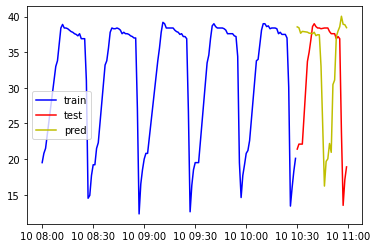

In [62]:
pl.plot(tr_d['temp1'], 'b-', label = 'train')
pl.plot(te_d['temp1'], 'r-', label = 'test')
pl.plot(te_d['pred'], 'y-', label = 'pred')
pl.legend()

pl.show()